In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from imgaug import augmenters as iaa
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torchsummary import summary


folder = r'C:\Users\Administrator\Documents\Computer-Vision\fmnist'

train_fmnist = datasets.FashionMNIST(folder, download = True, train=True)
validation_fmnist = datasets.FashionMNIST(folder, download=True, train=False)

image_train, label_train = train_fmnist.data, train_fmnist.targets
image_validation, label_validation = validation_fmnist.data, validation_fmnist.targets

class Data(Dataset):
    def __init__(self, x, y):
        super().__init__()
        x = x.float() / 255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

def DataLoaders():
    train_dl = DataLoader(Data(image_train, label_train), batch_size = 64, shuffle = True)
    validation_dl = DataLoader(Data(image_validation, label_validation), batch_size = 64, shuffle = True)
    return train_dl, validation_dl

train_dl, validation_dl = DataLoaders()

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3)
        self.maxp1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3)
        self.maxp2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        self.flat1 = nn.Flatten()
        self.line1 = nn.Linear(3200, 256)
        self.relu3 = nn.ReLU()
        self.line2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxp2(x)
        x = self.relu2(x)
        x = self.flat1(x)
        x = self.line1(x)
        x = self.relu3(x)
        x = self.line2(x)
        return x

def compile():
    model = Model()
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                               factor = 0.5,
                                               patience = 2,
                                               threshold = 0.001,
                                               verbose = True,
                                               min_lr = 0.01,
                                               threshold_mode = 'abs')

    return model, loss_function, optimizer, scheduler

model, loss_function, optimizer, scheduler = compile()

def for_training(x, y, model, loss_function, optimizer):
    model.train()
    optimizer.zero_grad()
    predicted = model(x)
    loss = loss_function(predicted, y)
    loss.backward()
    optimizer.step()
    accuracy = (torch.argmax(predicted, dim = 1) == y).float().mean().item()
    return loss.item(), accuracy

def for_validation(x, y, model, validation_dl, loss_function):
    model.eval()
    val_loss, val_accuracy = [], []
    for x, y, in validation_dl:
        prediction = model(x)
        loss = loss_function(prediction, y)
        acc = (torch.argmax(prediction, dim = 1) == y).float().mean().item()
        val_loss.append(loss.item())
        val_accuracy.append(acc)
        return np.mean(val_accuracy), np.mean(val_loss)


epochs = 10
train_loss, train_accuracy = [], []
for epoch in range(10):
    epoch_loss, epoch_accuracy = [], []
    for x, y in train_dl:
        loss, accuracy = for_training(x, y, model, loss_function, optimizer)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_loss)
    mean_epoch_loss = np.mean(epoch_loss)
    mean_epoch_accuracy = np.mean(epoch_accuracy)
    print(f'epoch {epoch+1}/{epochs} \Train accuracy: {mean_epoch_accuracy} Train_loss: {mean_epoch_loss}')

    with torch.no_grad():
        mean_val_accuracy, mean_val_loss = for_validation(x, y, model, validation_dl, loss_function)
        print(f"Validation accuracy: {mean_val_accuracy} Validation loss: {mean_val_loss}\n")
    scheduler.step(mean_val_loss)

In [ ]:
from torchsummary import summary

summary(model, (1, 28, 28))

In [ ]:
image = 232
img = image_train[image]/255
img = img.view(28, 28)
img2 = np.roll(img, 1, axis = 1)
img3 = torch.Tensor(img2).unsqueeze(0).unsqueeze(0)
predict = model(img3).detach().numpy()
plt.title(validation_fmnist.classes[np.argmax(predict)])
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data transformations including augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 datasets
train_data = datasets.CIFAR10(root=folder, train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root=folder, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x4
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Model, loss, optimizer, and scheduler
model = CNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(dim=1) == target).sum().item()
    return total_loss / len(train_loader), correct / len(train_loader.dataset)

# Testing function
def test(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            correct += (output.argmax(dim=1) == target).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)

# Train and evaluate the model
num_epochs = 50
best_acc = 0
early_stop_counter = 0
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test(model, test_loader, criterion)
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


<h1>Object Detection</h1>

<h1>Region-based Convolutional Neural Network

In [ ]:
# Using the felzenszwalb for simple Image segmentation
from torch_snippets import *
from skimage.segmentation import felzenszwalb

img = read('Hemanvi.jpeg', 1)
segmented = felzenszwalb(img, scale=200, min_size=100)
subplots(
    [img, segmented],
    titles = ['Original Image', 'Segmented Image'],
    sz = 5,
    nc=2
)

In [ ]:
from torch_snippets import *
import selectivesearch
import torch

img = read('Hemanvi.jpeg', 1)

def region_proposal(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale = 200, min_size = 100)
    image_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05 * image_area): continue
        if r['size'] > (1 * image_area) : continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))

    return candidates

x = region_proposal(img)

In [ ]:
def IoU(boxa, boxb, epsilon = 1e-5):
    x1 = max(boxa[0], boxb[0])
    y1 = max(boxa[1], boxb[1])
    x2 = min(boxa[2], boxb[2])
    y2 = min(boxa[3], boxb[3])
    width = x2- x1
    height = y2- y1
    if (width<0) or (height<0): return 0.0
    area_overlap = width * height
    area_a = (boxa[2] - boxa[0]) * (boxa[3] - boxa[1])
    area_b = (boxb[2] - boxb[0]) * (boxb[3] - boxb[1])
    combined_area = area_a + area_a - area_overlap
    iou = area_overlap / (combined_area + epsilon)
    return iou

In [ ]:
from torch_snippets import *
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchsummary import summary
from torchvision import transforms as T, datasets, models
from torchvision.ops import nms
from torch_snippets import *
import selectivesearch

image_root = r'/home/zkllmt/Documents/AI Section/Datasets/Object Detection/open-images-bus-trucks/images/images'
df_ = pd.read_csv(r'/home/zkllmt/Documents/AI Section/Datasets/Object Detection/open-images-bus-trucks/df.csv')

class Data(Dataset):
    def __init__(self, df, root = image_root, transforms = None):
        self.df = df
        self.root = image_root
        self.transforms = transforms
        self.unique_IDs = self.df['ImageID'].unique()

    def __len__(self): return len(self.unique_IDs)

    def __getitem__(self, index) -> any:
        img_id = self.unique_IDs[index]
        file_path = f'{self.root}/{img_id}.jpg'
        img = read(file_path, 1)
        if self.transforms:
            img = self.transforms(img)

        h, w = img.shape[:2]
        df = self.df.copy()
        df = df[df['ImageID'] == img_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.int16).tolist()
        labels = df['LabelName'].tolist()
        return img, boxes, labels, file_path
data = Data(df)
#img, boxes, labels, file_path = data[2]
#show(img, bbs = boxes, texts=labels, text_sz=10, title = labels)

def get_candidates(img):
    lbls, regions = selectivesearch.selective_search(img, scale = 200, min_size=100)
    candidates = []
    img_area = np.prod(img.shape[:2])
    for i in regions:
        if i['rect'] in candidates: continue
        if i['size'] < (0.05 * img_area): continue
        if i['size'] > (1 * img_area): continue
        x, y, w, h = i['rect']
        candidates.append(list(i['rect']))
    return candidates

def get_iou(boxa, boxb, epsilon = 1e-5):
    x1 = max(boxa[0], boxb[0])
    y1 = max(boxa[1], boxb[1])
    x2 = min(boxa[2], boxb[2])
    y2 = min(boxa[3], boxb[3])

    width = (x2 - x1)
    height = (y2 - y1)

    if (width <0) or (height <0):
        return 0.0

    area_overlap = width * height

    area_a = (boxa[2] - boxa[0]) * (boxa[3] - boxa[1])
    area_b = (boxb[2] - boxb[0]) * (boxb[3] - boxb[1])
    combined = area_a + area_b - area_overlap
    iou = area_overlap / (combined + epsilon)
    return iou

FPATHS, GTBBS, CLSS, DELTAS, IOUS, ROIS = [],[],[],[],[],[]
N = 500

In [ ]:
for ix, (img, boxes, labels, file_path) in enumerate(data):
    if ix == 500: break

    H, W, C = img.shape
    candidates = get_candidates(img)
    candidates = np.array([(x, y, x+w, y+h) for x,y,w,h in candidates])
    ious, deltas, clss, rois = [],[],[],[]
    ious = np.array([[get_iou(candidate, _bb_) for candidate in candidates] for _bb_ in boxes]).T
    for jx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_ious = ious[jx]
        best_ious_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_ious_at]
        best_bb = _x, _y, _X, _Y = boxes[best_ious_at]

        if best_iou > 0.3: clss.append(labels[best_ious_at])
        else: clss.append("background")

        delta = np.array([cx-_x, cy-_y, cX-_X, cY-_Y]) / np.array([W, H, W, H])
        deltas.append(delta)
        rois.append(candidate / np.array([W, H, W, H]))

    FPATHS.append(file_path)
    GTBBS.append(boxes)
    CLSS.append(clss)
    DELTAS.append(deltas)
    IOUS.append(ious)
    ROIS.append(rois)

targets = pd.DataFrame(flatten(CLSS), columns=['Label'])
label2target = {l:t for t, l in enumerate(targets['Label'].unique())}
target2label = {t:l for l, t in label2target.items()}

def decode(_y):
    _, preds = _y.max(-1)
    return preds

normalize= T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
def preprocess_img(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.float()

In [ ]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.labels = labels
        self.deltas = deltas
        self.rois = rois
        self.gtbbs = gtbbs

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        img = read(fpath, 1)
        H, W, C = img.shape
        sh = np.array([W, H, W, H])
        gtbbs = self.gtbbs[ix]
        deltas = self.deltas[ix]
        labels = self.labels[ix]
        rois = self.rois[ix]
        bbs = np.array((rois)*sh).astype(np.uint16)
        crops = [img[y:Y, x:X] for (x,y,X,Y) in bbs]
        return img,crops,bbs,labels,deltas,gtbbs,fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas =[],[],[],[],[]
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to
        labels = torch.Tensor(labels).long()
        deltas = torch.Tensor(deltas).float()
        return input, labels, deltas


n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)



<h1>FASTER RCNN</h1>

In [ ]:
from torch_snippets import *
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, lr_scheduler
from torchsummary import summary
from torchvision import models, datasets, transforms as transforms
from torchvision.models import vgg16
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
import torchvision
from glob import glob
from tqdm import tqdm


image_root = r'/home/zkllmt/Documents/AI Section/Datasets/Object Detection/open-images-bus-trucks/images/images'
df = pd.read_csv(r'/home/zkllmt/Documents/AI Section/Datasets/Object Detection/open-images-bus-trucks/df.csv')

label2target = {l:t+1 for t, l in enumerate(df['LabelName'].unique())}
label2target['background'] = 0

target2label = {t:l for l, t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    return img.float()

class Data(Dataset):
    w, h = 224, 224
    def __init__(self, df, image_root = image_root):
        self.df = df
        self.image_dir = image_root
        self.files = glob(os.path.join(self.image_dir, '*'))
        self.image_infos = self.df.ImageID.unique()

    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        image_path = find(image_id, self.files)
        img = Image.open(image_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample = Image.BILINEAR)) / 255.
        df = self.df.copy()
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:, [0, 2]] *= self.w
        data[:, [1, 3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target

    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def __len__(self):
        return len(self.image_infos)


data = Data(df)

trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
train_ds = Data(trn_df)
test_ds = Data(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

def get_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Defining training and validation functions
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image for image in input)
    targets = [{k: v for k, v \
                in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(inputs, model):
    model.train()
#to obtain losses, model needs to be in train mode only
#Note that here we arn't defining the model's forward method
#hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image for image in input)
    targets = [{k: v for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

model = get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9,weight_decay=0.0005)
class Logger:
    def __init__(self, n_epochs):
        self.n_epochs = n_epochs
        self.epoch_logs = []

    def record(self, pos, **kwargs):
        # Display the logs as you progress
        print(f"Epoch {pos:.2f}: ", end="")
        for key, value in kwargs.items():
            print(f"{key}: {value:.4f} ", end="")
        print()  # Newline after each record

    def report_avgs(self, epoch):
        # Report average metrics at each epoch
        avg_logs = {key: sum([log[key] for log in self.epoch_logs]) / len(self.epoch_logs)
                    for key in self.epoch_logs[0]}
        print(f"Avg metrics at epoch {epoch}: {avg_logs}")

    def plot_epochs(self, metrics):
        # Dummy function for plotting
        print(f"Plotting metrics: {metrics}")


n_epochs = 5
log = Logger(n_epochs)

for epoch in range(n_epochs):
    # Training loop
    _n = len(train_loader)
    for ix, inputs in enumerate(tqdm(train_loader, desc=f"Training epoch {epoch+1}")):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]

        pos = (epoch + (ix + 1) / _n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), trn_regr_loss=regr_loss.item(),
                   trn_objectness_loss=loss_objectness.item(), trn_rpn_box_reg_loss=loss_rpn_box_reg.item())

    # Validation loop
    _n = len(test_loader)
    for ix, inputs in enumerate(tqdm(test_loader, desc=f"Validating epoch {epoch+1}")):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]

        pos = (epoch + (ix + 1) / _n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), val_regr_loss=regr_loss.item(),
                   val_objectness_loss=loss_objectness.item(), val_rpn_box_reg_loss=loss_rpn_box_reg.item())

    if (epoch + 1) % (n_epochs // 5) == 0:
        log.report_avgs(epoch + 1)

log.plot_epochs(['trn_loss', 'val_loss'])

<h1>YOLO (You Only Look Once)</h1>

In [ ]:
from ultralytics import YOLO, checks, hub
checks()

hub.login('7872b0b7def37af38e72e525b78bef0c3c74e4facd')

model = YOLO('https://hub.ultralytics.com/models/VZ8ePp9uuGbBFLLbUD2h')
results = model.train()

<h1>SSD Object Detection</h1>

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from model import SSD300, MultiBoxLoss
from torch_snippets import *
from torch_snippets.torch_loader import Report

# Paths and Parameters
ROOT = r'/home/zkllmt/Documents/AI Section/Datasets/Object Detection/open-images-bus-trucks/images/images'
CSV_PATH = r"/home/zkllmt/Documents/AI Section/Datasets/Object Detection/open-images-bus-trucks/df.csv"
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
N_EPOCHS = 20
IMG_SIZE = 300

# Dataset Preprocessing and Setup
df_raw = pd.read_csv(CSV_PATH)
df = df_raw.copy()
label2target = {l: t + 1 for t, l in enumerate(df['LabelName'].unique())}
label2target["Background"] = 0
target2label = {t: l for l, t in label2target.items()}
n_classes = len(label2target)

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), normalize])

class OpenImagesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.image_ids = dataframe['ImageID'].unique()
        self.image_paths = {img_id: os.path.join(root_dir, f"{img_id}.jpg") for img_id in self.image_ids}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = self.image_paths[img_id]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        annotations = self.data[self.data['ImageID'] == img_id]
        boxes = annotations[['XMin', 'YMin', 'XMax', 'YMax']].values
        boxes[:, [0, 2]] *= IMG_SIZE
        boxes[:, [1, 3]] *= IMG_SIZE
        labels = [label2target[label] for label in annotations['LabelName']]
        return img, torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

def get_dataloaders(df, batch_size):
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dataset = OpenImagesDataset(train_df, ROOT, transform)
    val_dataset = OpenImagesDataset(val_df, ROOT, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

def collate_fn(batch):
    images, boxes, labels = zip(*batch)
    images = torch.stack(images)
    return images, list(boxes), list(labels)

train_loader, val_loader = get_dataloaders(df, BATCH_SIZE)

model = SSD300(n_classes=n_classes, device=None)
criterion = MultiBoxLoss(model.priors_cxcy, device=None)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, boxes, labels in loader:
        images = images.to(device)
        optimizer.zero_grad()
        loc_preds, cls_preds = model(images)
        loss = criterion(loc_preds, cls_preds, boxes, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    for images, boxes, labels in loader:
        images = images.to(device)
        loc_preds, cls_preds = model(images)
        loss = criterion(loc_preds, cls_preds, boxes, labels)
        running_loss += loss.item()
    return running_loss / len(loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
log = Report(n_epochs=N_EPOCHS)

for epoch in range(N_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_one_epoch(model, val_loader, criterion, device)
    scheduler.step()

    log.record(epoch + 1, trn_loss=train_loss, val_loss=val_loss)
    print(f"Epoch {epoch+1}/{N_EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

torch.save(model.state_dict(), "ssd300_bus_truck.pth")
print("Training complete and model saved.")

<h1>Image Segmentation</h1>

<center><h2>U-Net Architecture</h2>

<center>

![image.png](attachment:image.png)


In [ ]:
#  ====================================== Upscaling Example ======================================
import torch
import torch.nn as nn

x = torch.ones(3, 3)
y = torch.tensor([[1, 0, 1, 0, 1], torch.zeros(5), [1, 0, 1, 0, 1], torch.zeros(5), [1, 0, 1, 0, 1]])
s_p = torch.tensor([[0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 1, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 1, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 1, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0]])
f_k = torch.tensor([[1, 1], [1, 1]])


# TODO finish this later
# NOTE Perform convolution (s_p, f_k)


0: 480x640 10 persons, 370.4ms
Speed: 4.9ms preprocess, 370.4ms inference, 25.3ms postprocess per image at shape (1, 3, 480, 640)


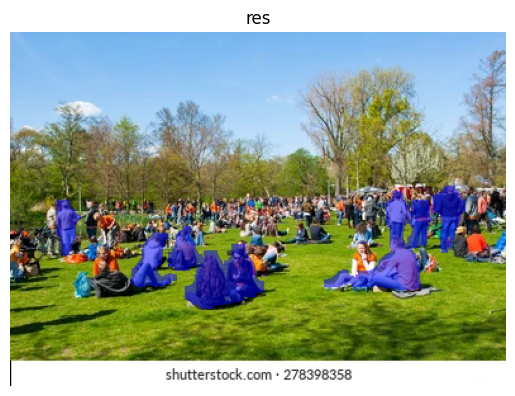

In [ ]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

model = YOLO("yolo11n-seg.pt")

img = read(r'/home/zkllmt/Downloads/ok.webp')

res = model(img)[0]

highlighted_image = img.copy()


class_colors = {
    "person": [0, 0, 255],
    "umbrella": [255, 0, 0],
    "bottle": [0, 255, 0],
}

def get_class_color(class_name):
    return class_colors.get(class_name, [np.random.randint(0, 255) for _ in range(3)])

for i in range(len(res.masks)):
    mask = res.masks.data[i].cpu().numpy()
    mask_binary = (mask > 0).astype(int)

    mask_resized = resize(mask_binary, (img.shape[0], img.shape[1]), mode='reflect', anti_aliasing=True)

    class_idx = int(res.boxes[i].cls)
    class_name = res.names[class_idx]

    color = get_class_color(class_name)

    mask_colored = np.zeros_like(img)
    mask_colored[mask_resized > 0] = color

    highlighted_image[mask_resized > 0] = cv2.addWeighted(
        img, 1 - 0.5, mask_colored, 0.5, 0)[mask_resized > 0]

plt.imshow(highlighted_image)
plt.title("res")
plt.axis('off')
plt.show()


<h1>Realtime Instance segmentaion but wil YOLO only</h1>

In [ ]:
import cv2
from torch_snippets import *
from skimage.transform import resize
from ultralytics import YOLO
import numpy as np
import datetime
import random

model = YOLO("yolo11n-seg.pt")

cam = cv2.VideoCapture(2)

alpha = 0.5

class_colors = {
    "person": [0, 0, 255],
    "umbrella": [255, 0, 0],
    "bottle": [0, 255, 0],
}

def get_class_color(class_name):
    return class_colors.get(class_name, [random.randint(0, 255) for _ in range(3)])

while True:
    ret, frame = cam.read()
    if not ret:
        print("Cam not found")
        break

    res = model(frame)[0]

    if res.masks is not None and len(res.masks) > 0:
        highlighted_frame = frame.copy()

        for i in range(len(res.masks)):
            mask = res.masks.data[i].cpu().numpy()
            mask_binary = (mask > 0).astype(int)

            mask_resized = resize(mask_binary, (frame.shape[0], frame.shape[1]), mode='reflect', anti_aliasing=True)

            class_idx = int(res.boxes[i].cls)
            class_name = res.names[class_idx]
            color = get_class_color(class_name)

            mask_colored = np.zeros_like(frame)
            mask_colored[mask_resized > 0] = color

            highlighted_frame[mask_resized > 0] = cv2.addWeighted(frame, 1 - alpha, mask_colored, alpha, 0)[mask_resized > 0]

        cv2.imshow('Camera', highlighted_frame)
    else:
        cv2.imshow('Camera', frame)

    key = cv2.waitKey(1) & 0xFF

    if key == 27:
        break

    if key == ord(" "):
        filename = f'{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png'
        cv2.imwrite(f'./saved_images/{filename}', frame)
        print(f"Image saved as {filename}")

cam.release()
cv2.destroyAllWindows()

In [ ]:
import matplotlib.pyplot as plt

masks = res.masks

if masks is not None:
    mask = masks[0].data.cpu().numpy()
    print("Mask shape:", mask.shape)

    if len(mask.shape) > 2:
        mask = mask[0, :, :]

    print("Adjusted mask shape:", mask.shape)

    if mask.max() == 1:
        mask = mask * 255

    plt.imshow(mask, cmap='jet')
    plt.title("Segmentation Mask")
    plt.axis('off')
    plt.show()


# Autoencoders and Image Manipulation

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch_snippets import *
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary

dir = r'C:\Users\Administrator\Documents\Computer-Vision'
device = "gpu" if torch.cuda.is_available() else "cpu"

trnsfrms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = [0.5], std = [0.5]),
    T.Lambda(lambda x: x.to(device))

])

trn_ds = MNIST(root = dir, download = True, train = True, transform = trnsfrms)
val_ds = MNIST(root = dir, download = True, train = False, transform = trnsfrms)

BATCH_SIZE = 32
trn_dl = DataLoader(trn_ds, batch_size=BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle = False)

class Auto_Encoder(nn.Module):
    def __init__(self, latend_dim):
        super().__init__()
        self.latend_dim = latend_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latend_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latend_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

def for_training(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(input)
    loss = criterion(input, Y_hat)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def for_eval(input, model, criterion):
    model.eval()
    Y_hat = model(input)
    loss = criterion(input, Y_hat)
    return loss

model = Auto_Encoder(50)
loss_fn = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr = 0.001, weight_decay=1e-5)

epochs = 10
for epoch in range(epochs):
    print(f"epoch: {epoch}")
    for ix, (data, _) in enumerate(trn_dl):
        loss = for_training(data, model, loss_fn, optimizer)
        print(f"{ix + 1} training loss: {loss * 100:.2f}%")

    for ix, (data, _) in enumerate(val_dl):
        loss = for_training(data, model, loss_fn, optimizer)
        print(f"{ix + 1} validation loss: {loss * 100:.2f}%")

for _ in range(5):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

# Convolutional Autoencoder

![convolutional_autoencoder.png](attachment:convolutional_autoencoder.png)

In [2]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch_snippets import *
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary

dir = r'/content/sample_data'
device = "cuda" if torch.cuda.is_available() else "cpu"

trnsfrms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = [0.5], std = [0.5]),
    T.Lambda(lambda x: x.to(device))

])

trn_ds = MNIST(root = dir, download = True, train = True, transform = trnsfrms)
val_ds = MNIST(root = dir, download = True, train = False, transform = trnsfrms)

BATCH_SIZE = 32
trn_dl = DataLoader(trn_ds, batch_size=BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle = False)

class Conv_Auto_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def for_training(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(input)
    loss = criterion(input, Y_hat)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def for_eval(input, model, criterion):
    model.eval()
    Y_hat = model(input)
    loss = criterion(input, Y_hat)
    return loss

model = Conv_Auto_Encoder().to(device)
loss_fn = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr = 0.001, weight_decay=1e-5)

epochs = 10
for epoch in range(epochs):
    print(f"epoch: {epoch}")
    for ix, (data, _) in enumerate(trn_dl):
        loss = for_training(data, model, loss_fn, optimizer)
        print(f"epoch {epoch + 1}-> {ix + 1} training loss: {loss * 100:.2f}%")

    for ix, (data, _) in enumerate(val_dl):
        loss = for_training(data, model, loss_fn, optimizer)
        print(f"epoch {epoch + 1}-> {ix + 1} validation loss: {loss * 100:.2f}%")

Streaming output truncated to the last 5000 lines.
epoch 8-> 1567 training loss: 5.12%
epoch 8-> 1568 training loss: 4.22%
epoch 8-> 1569 training loss: 4.65%
epoch 8-> 1570 training loss: 3.55%
epoch 8-> 1571 training loss: 3.77%
epoch 8-> 1572 training loss: 3.85%
epoch 8-> 1573 training loss: 3.86%
epoch 8-> 1574 training loss: 4.15%
epoch 8-> 1575 training loss: 4.17%
epoch 8-> 1576 training loss: 4.33%
epoch 8-> 1577 training loss: 3.80%
epoch 8-> 1578 training loss: 4.35%
epoch 8-> 1579 training loss: 4.08%
epoch 8-> 1580 training loss: 3.98%
epoch 8-> 1581 training loss: 3.73%
epoch 8-> 1582 training loss: 4.68%
epoch 8-> 1583 training loss: 4.58%
epoch 8-> 1584 training loss: 4.87%
epoch 8-> 1585 training loss: 4.82%
epoch 8-> 1586 training loss: 4.44%
epoch 8-> 1587 training loss: 5.14%
epoch 8-> 1588 training loss: 4.83%
epoch 8-> 1589 training loss: 4.61%
epoch 8-> 1590 training loss: 4.35%
epoch 8-> 1591 training loss: 4.67%
epoch 8-> 1592 training loss: 4.97%
epoch 8-> 159

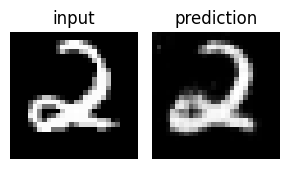

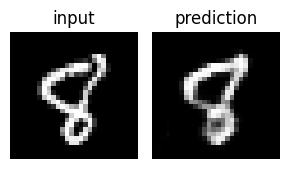

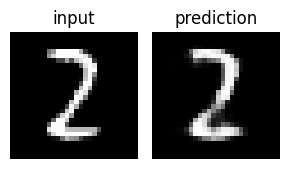

In [5]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

# Grouping similar images using t-SNE

<h5>Plotting <i><b>embedding (bottleneck)</b></i> vectors in a 2-dimensional space. <br>
We can reduce the 64-dimensional vector of convolutional autoencoder to a 2-<br>
dimensional space by using a technique called t-SNE (<b>t-Distributed Schochastic Neighbor Embedding</b>).</h5>

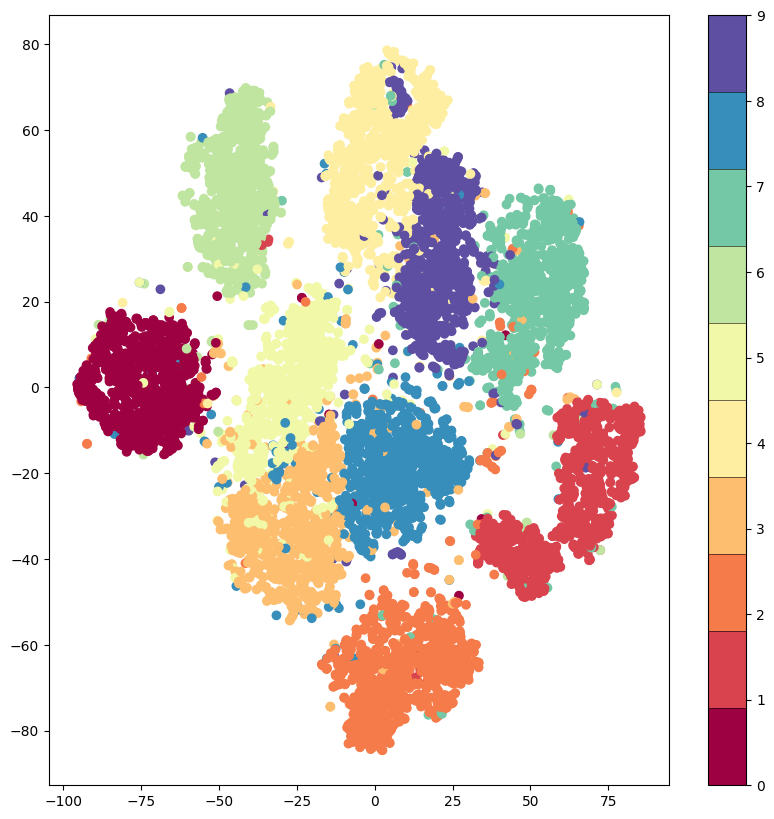

In [10]:
from sklearn.manifold import TSNE
import torch
tsne = TSNE(2)

latent_vectors, classes = [], []

for im, clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im), -1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

clustered = tsne.fit_transform(latent_vectors)

fig = plt.figure(figsize=(10, 10))
cmap = plt.get_cmap("Spectral", 10)
plt.scatter(*zip(*clustered), c = classes, cmap = cmap)
plt.colorbar(drawedges = True)
plt.show()

We can see that images of the same class are clustered together, which reinforces our <br>
understanding that the bottleneck layer has values in such a way that images that <br>
look similar will have similar values. <br><br>
So far, we have learned about using autoencoders to group similar images together. <br>
In the next section, we will learn about using autoencoders to generate new images.

# Understanding variational autoencoders

In [13]:
latent_vectors, classes = [], []

for im, clss in val_dl:
  latent_vectors.append(model.encoder(im))
  classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)
rand_vectors = []

for col in latent_vectors.transpose(1, 0):
  mu, sigma = col.mean(), col.std()
  rand_vectors.append(sigma * torch.randn(1, 100) + mu)

rand_vectors = torch.cat(rand_vectors).transpose(1, 0).to(device)
fig,ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
  img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
  show(img, ax=next(ax))

array([[4.1215377 , 4.1215377 , 0.71495676, ..., 0.        , 0.        ,
        0.        ],
       [4.260973  , 4.260973  , 2.3768969 , ..., 0.        , 0.        ,
        0.        ],
       [2.40875   , 2.40875   , 1.0843111 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.004725  , 4.004725  , 2.3509836 , ..., 0.        , 0.        ,
        0.        ],
       [3.0030797 , 3.0030797 , 2.462001  , ..., 0.        , 0.        ,
        0.        ],
       [5.779899  , 5.779899  , 2.8522882 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

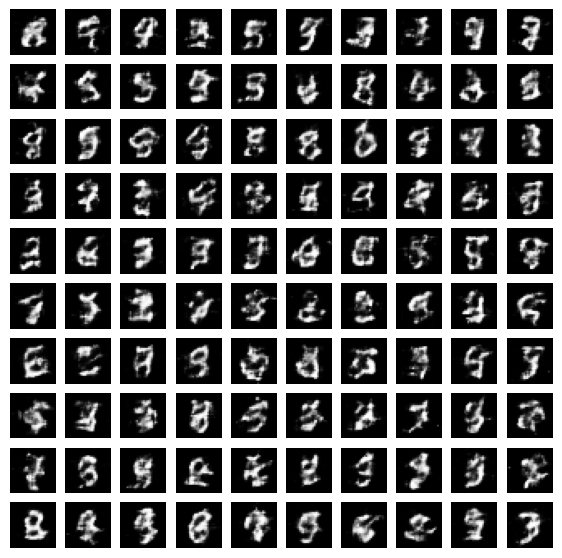